In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler

import shutil
import os

2024-08-12 10:34:44.911490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define the custom confusion matrix plotting function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if title:
        plt.title(title)

In [4]:
# # Function to calculate false positive rate and false negative rate from confusion matrix
def calculate_fp_fn_rates(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    return fpr, fnr

In [5]:
df = pd.read_csv("data.csv")
df.shape

(6819, 96)

In [6]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [7]:
df.isnull().sum().sum()

0

In [8]:
df['Bankrupt?'].unique()

array([1, 0])

In [9]:
# Get the counts of each class in the 'dss' column
bankrupt_counts = df['Bankrupt?'].value_counts().reset_index()

# Rename the columns for clarity
bankrupt_counts.columns = ['Class', 'Count']

# Display the DataFrame
bankrupt_counts

,Class,Count
0,0,6599
1,1,220


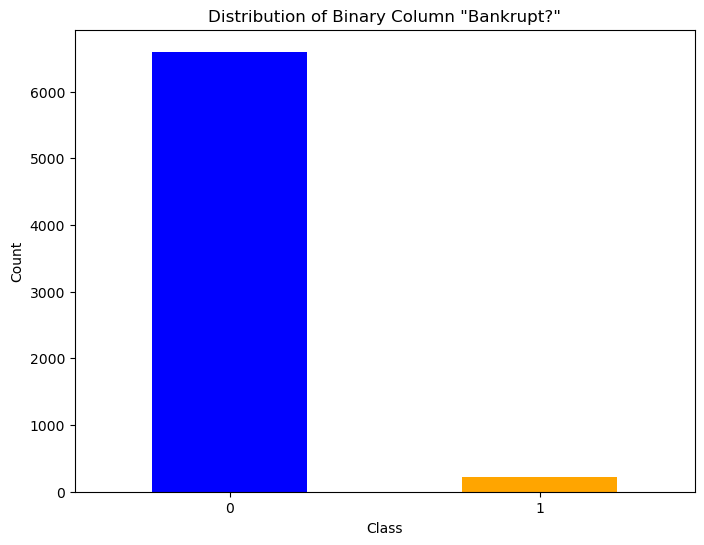

In [10]:
# Plot the distribution of the binary column 'dss'
plt.figure(figsize=(8, 6))
df['Bankrupt?'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Binary Column "Bankrupt?"')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [11]:
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=8)


## NN time

In [12]:
# Define custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [13]:
# Define the log directory
log_dir = "logs"

# Clear the log directory
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# Create the log directory if it doesn't exist
os.makedirs(log_dir)

## lets just do 16 nodes, 3 layers

In [14]:
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import AUC


# Ensure y_train is a NumPy array
y_train = np.array(y_train)

k = 5  

cv_results = []
models = []

kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_no = 1
fold_metrics = []
start_time = time.time()
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define the model
    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))

    # hidden layers
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))

    #output layer
    model.add(Dense(1, activation='sigmoid'))

    NAME = "regNN-fold-{}".format(fold_no)
    tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)

    # Compile the model with accuracy, AUC, and F1 score as metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc'), F1Score()])

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32,
                        validation_data=(X_val_fold, y_val_fold), verbose=1,
                        callbacks=[tensorboard, early_stopping])

    # Evaluate the model on the validation fold
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracy = scores[1]
    auc = scores[2]
    f1 = scores[3]
    print(f'Score for fold {fold_no}: Accuracy of {accuracy*100:.2f}%, AUC of {auc*100:.2f}%, F1 Score of {f1*100:.2f}%')
    fold_metrics.append({'fold': fold_no, 'accuracy': accuracy, 'auc': auc, 'f1': f1})

    # Save the model for this fold
    models.append(model)

    fold_no += 1


In [15]:

# Print all metrics for each fold
print("\nMetrics for each fold:")
for metrics in fold_metrics:
    print(f"Fold {metrics['fold']}: Accuracy: {metrics['accuracy']*100:.2f}%, AUC: {metrics['auc']*100:.2f}%, F1 Score: {metrics['f1']*100:.2f}%")

# Select the best fold based on desired criteria (e.g., highest AUC, then highest Accuracy)
best_fold = max(fold_metrics, key=lambda x: (x['auc'], x['accuracy'], x['f1']))
best_model = models[best_fold['fold']-1]

print(f'\nBest fold: {best_fold["fold"]} with Accuracy: {best_fold["accuracy"]*100:.2f}%, AUC: {best_fold["auc"]*100:.2f}%, F1 Score: {best_fold["f1"]*100:.2f}%')

# Use the best model to make predictions
# Example prediction: best_model.predict(new_data)

In [56]:
y_pred_prob = model.predict(X_test).flatten()
end_time = time.time()

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Understanding Thresholds in the `roc_curve` Function

The `roc_curve` function from `sklearn.metrics` evaluates the performance of a binary classifier by examining various thresholds. Here's how it determines and uses these thresholds:

1. **Predicted Probabilities (`y_pred`):**
   - These are the continuous output values from your classifier, representing the probability or confidence that a given instance belongs to the positive class.

2. **Unique Sorted Thresholds:**
   - The `roc_curve` function extracts all unique values from `y_pred` and sorts them in descending order. These unique values become the candidate thresholds.
   
3. **Threshold Evaluation:**
   - For each unique threshold, the function calculates the True Positive Rate (TPR) and False Positive Rate (FPR).
   - By iterating over the sorted unique values, the function evaluates the classifier's performance at each threshold.

AUC: 0.877251434980537
Optimal threshold (Youden's J): 0.010114878
Optimal threshold (Distance): 0.010114878


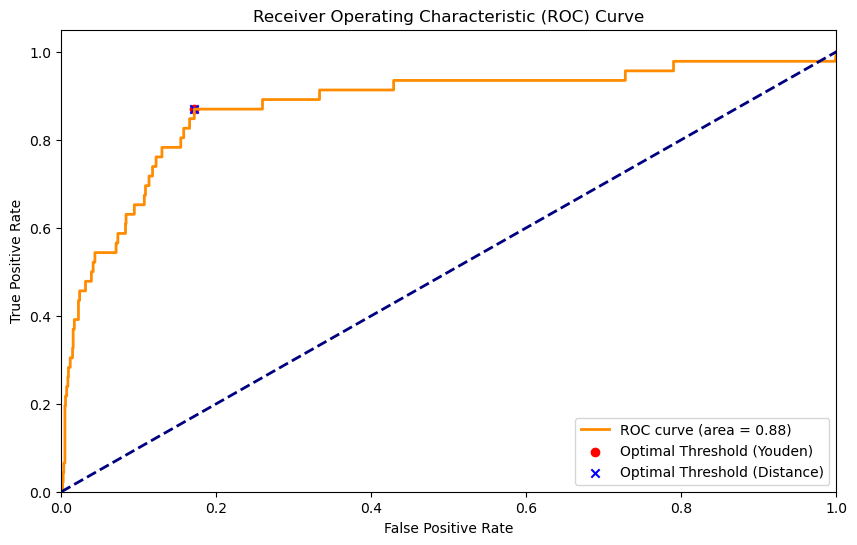

In [57]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Find the optimal threshold by maximizing Youden's J statistic
optimal_idx_youden = np.argmax(tpr - fpr)
optimal_threshold_youden = thresholds[optimal_idx_youden]
print("Optimal threshold (Youden's J):", optimal_threshold_youden)

# Find the optimal threshold by minimizing the distance to the top-left corner (0, 1)
optimal_idx_distance = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
optimal_threshold_distance = thresholds[optimal_idx_distance]
print("Optimal threshold (Distance):", optimal_threshold_distance)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot the optimal points
plt.scatter(fpr[optimal_idx_youden], tpr[optimal_idx_youden], marker='o', color='red', label='Optimal Threshold (Youden)')
plt.scatter(fpr[optimal_idx_distance], tpr[optimal_idx_distance], marker='x', color='blue', label='Optimal Threshold (Distance)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [58]:
# Set the threshold
threshold = optimal_threshold_youden

# Convert continuous outputs to binary
binary_outputs = (y_pred_prob >= threshold).astype(int)

# print("Continuous outputs:", y_pred)
# print("Binary outputs:", binary_outputs)

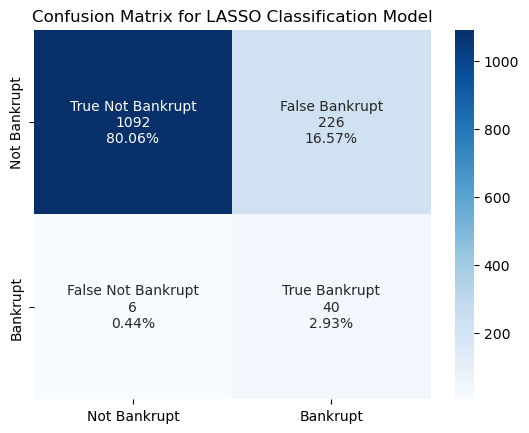

In [59]:
nn_report = classification_report(y_test, binary_outputs, target_names=['Democrat', 'Republican'], output_dict=True)
# Compute the confusion matrix
# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, binary_outputs)

# Define the category names
categories = ['Not Bankrupt', 'Bankrupt']
labels = ['True Not Bankrupt', 'False Bankrupt', 'False Not Bankrupt', 'True Bankrupt']
# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      title='Confusion Matrix for LASSO Classification Model')
plt.show()

In [60]:
nn_metrics = []
# LassoCV model metrics
fpr, fnr = calculate_fp_fn_rates(cf_matrix)
nn_metrics.append({
    'model': 'NN',
    'estimation_time_sec': round(end_time - start_time, 2),
    'accuracy': round(nn_report['accuracy'], 3),
    'f1-score': round(nn_report['weighted avg']['f1-score'], 3),
    'auc': round(roc_auc, 3),
    'false_positive_rate': round(fpr, 3),
    'false_negative_rate': round(fnr, 3)
})

nn_metrics_df = pd.DataFrame(nn_metrics)
nn_metrics_df

,model,estimation_time_sec,accuracy,f1-score,auc,false_positive_rate,false_negative_rate
0,NN,183.35,0.83,0.882,0.877,0.171,0.13


In [61]:
# write results to csv

nn_metrics_df.to_csv('metrics.csv', mode='a', index=False, header=False)